## Set Configuration Parameters

In [2]:
NUM_SENTENCES = 20000 # Use only the first 20,000 records.
MAX_NUM_WORDS = 20000 # Use 20,000 words for tokenizing
MAX_SENT_LEN = 50

EMBEDDING_SIZE = 100

LSTM_NEURONS = 100

BATCH_SIZE = 64
EPOCHS = 5

## Importing and Preprocessing the Data
* Use only the first 20,000 records to train the model.
* Input does not need to be processed.
* Two copies of the translated sentence is needed to be generated.
  * with *start-of-sentence* token
  * with *end-of-sentence* token
* Each record should have the words/phrases in both languages separated by a tab
* The first is English, and the next is Spanish
    * English -> Input, Spanish -> temp output to be tagged 

In [3]:
from datasets import load_dataset

# Define the number of sentences you want to process
#NUM_SENTENCES = 1000  # You can adjust this value

# Load the dataset
data_file = load_dataset("cfilt/iitb-english-hindi", split="train")

# Initialize lists for inputs and outputs
inputs = []
outputs_i = []
outputs = []

count = 0

# Loop through the dataset and collect inputs and outputs
for line in data_file:
    count += 1
    if count > NUM_SENTENCES:
        break
    # Assuming the dataset has 'translation' field with 'en' for English and 'hi' for Hindi
    ip = line['translation']['en']
    temp_op = line['translation']['hi']
    
    # Add start of sentence token <sos> and end of sentence token <eos>
    op_i = '<sos> ' + temp_op
    op = temp_op + ' <eos>'
    
    inputs.append(ip)
    outputs_i.append(op_i)
    outputs.append(op)

# Print the statistics
print('Total inputs =', len(inputs))
print('Total intermediate outputs =', len(outputs_i))
print('Total outputs =', len(outputs))
print('\nSample:')
print(inputs[100])
print(outputs_i[100])
print(outputs[100])


C:\Users\321an\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total inputs = 20000
Total intermediate outputs = 20000
Total outputs = 20000

Sample:
Script Recorder
<sos> लिपि रेकोर्डर
लिपि रेकोर्डर <eos>


## Tokenization
* Divide input sentences into the corresponding list of words
* Convert the input words to integers  
* Create the word-to-index dictionary for the input
* Get the number of unique words in the input
* Get the length of the longest sentence in the input
* Divide output and internediary output sentences into the corresponding list of words
* Convert the output words to integers  
* Create the word-to-index dictionary for the output
* Get the number of words in the output
* Get the length of the longest sentence in the output

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(inputs)

inputs_seq = input_tokenizer.texts_to_sequences(inputs)

inputs_word2index = input_tokenizer.word_index
print('Total unique words in input:', len(inputs_word2index))

inputs_numwords = len(inputs_word2index)+1

inputs_maxlen = max(len(s) for s in inputs_seq)
print('Length of longest sentence in input:', inputs_maxlen)

output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(outputs_i + outputs)

outputs_i_seq = output_tokenizer.texts_to_sequences(outputs_i)
outputs_seq = output_tokenizer.texts_to_sequences(outputs)

outputs_word2index = output_tokenizer.word_index
print('Total unique words in output:', len(outputs_word2index))

outputs_numwords = len(outputs_word2index)+1

outputs_maxlen = max(len(s) for s in outputs_seq)
print('Length of longest sentence in output:', outputs_maxlen)

Total unique words in input: 2036
Length of longest sentence in input: 62
Total unique words in output: 2937
Length of longest sentence in output: 42


## Padding

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_sequences = pad_sequences(inputs_seq, maxlen=inputs_maxlen)
print('encoder_input_sequences shape:', encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(outputs_i_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_inputs_sequences shape:', decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(outputs_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_output_sequences shape:', decoder_output_sequences.shape)

encoder_input_sequences shape: (20000, 62)
decoder_inputs_sequences shape: (20000, 42)
decoder_output_sequences shape: (20000, 42)


## Word Embeddings

In [6]:
from numpy import asarray, zeros

embeddings_dict = dict()

glove_file = open('glove/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector

glove_file.close()

num_words = min(MAX_NUM_WORDS, len(inputs_word2index)+1)

embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in inputs_word2index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Create Model

### Define the layers, inputs, and outputs
* Create embedding layer
* Define the decoder output
  * Each word in the output can be any of the total number of unique words in the output.
  * The length of an output sentence is the length of the longest sentence in the output.
  * For each input sentence, we need a corresponding output sentence. 
  * *Hence*, **shape of the output** = (no. of inputs, length of the output sentence, no. of words in the output)
* Create one-hot encoded output vector for the output Dense layer
  * Assign 1 to the column number that corresponds to the integer representation of the word.
* Create encoder and decoder
  * Input to the encoder will be the sentence in English
  * Output from the encoder will be the hidden state and cell state of the LSTM
  * Inputs to the decoder will be the the hidden state and cell state from the encoder
  * Output from the decoder will be the sentence with start of sentence tag appended at the beginning
* Define final output layer
  * Dense layer

In [8]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from scipy.sparse import lil_matrix

encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=inputs_maxlen)
decoder_embedding_layer = Embedding(outputs_numwords, LSTM_NEURONS)

decoder_outputs_onehot = zeros((len(inputs), outputs_maxlen, outputs_numwords), dtype='float32')
print('decoder_outputs_onehot shape:', decoder_outputs_onehot.shape)

for i, d in enumerate(decoder_outputs):
    for t, w in enumerate(d):
        decoder_outputs_onehot[i, t, w] = 1

encoder_inputs = Input(shape=(inputs_maxlen,))
encoder_inputs_emb = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NEURONS, return_state=True)
encoder_outputs, h, c = encoder(encoder_inputs_emb)
encoder_states = [h, c]

decoder_inputs = Input(shape=(outputs_maxlen,))
decoder_inputs_emb = decoder_embedding_layer(decoder_inputs)
decoder = LSTM(LSTM_NEURONS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs_emb, initial_state=encoder_states)

output_dense_layer = Dense(outputs_numwords, activation='softmax')
outputs = output_dense_layer(decoder_outputs)

decoder_outputs_onehot shape: (20000, 42, 2938)


C:\Users\321an\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'decoder_outputs' is not defined

### Compile the model

In [47]:
from tensorflow.keras.models import Model

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 62)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 62, 100)   │    203,700 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 42, 100)   │    293,800 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 100),     │     80,400 │ embedding_18[0][… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 42, 100), │     80,400 │ embedding_19[0][… │
│                     │ (None, 100),      │            │ lstm_4[0][1],     │
│                     │ (None, 100)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 42, 2938)  │    296,738 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 955,038 (3.64 MB)

 Trainable params: 955,038 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='models/model_trn_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Train the model

In [49]:
trn = model.fit([encoder_input_sequences, decoder_input_sequences],
               decoder_outputs_onehot, 
               batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1
               )

Epoch 1/5


TypeError: Failed to convert elements of SparseTensor(indices=Tensor("data_2:0", shape=(None, 2), dtype=int64), values=Tensor("data_3:0", shape=(None,), dtype=float32), dense_shape=Tensor("data_4:0", shape=(2,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.

In [31]:
import pickle

pickle.dump(model, open('models/model_trn.sav', 'wb'))

## Modify model for prediction

### Encoder model remains the same

In [24]:
encoder_model = Model(encoder_inputs, encoder_states)
print(encoder_model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6, 100)            377000    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 100), (None, 100) 80400     
Total params: 457,400
Trainable params: 457,400
Non-trainable params: 0
_________________________________________________________________
None


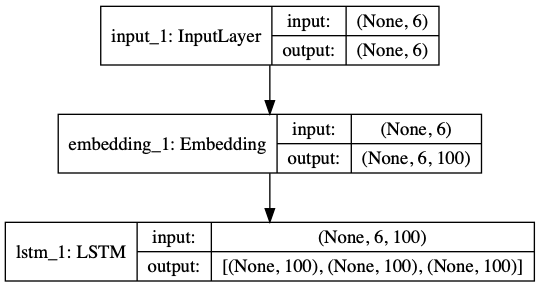

In [32]:
plot_model(encoder_model, to_file='models/model_prd_enc_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
pickle.dump(encoder_model, open('models/model_prd_enc.sav', 'wb'))

### Define the layers, inputs, and outputs for decoder model
* The encoder model remains the same.  
* In each step we need the decoder hidden and the cell states.
* In each step there is only single word in decoder input. So, decoder embedding layer needs to be modified.
* The decoder output is defined.
* The decoder output is passed through dense layer to make predictions.

In [16]:
decoder_input_h = Input(shape=(LSTM_NEURONS,))
decoder_input_c = Input(shape=(LSTM_NEURONS,))
decoder_input_states = [decoder_input_h, decoder_input_c]

decoder_input_word = Input(shape=(1,))
decoder_input_word_emb = decoder_embedding_layer(decoder_input_word)

decoder_outputs, h, c = decoder(decoder_input_word_emb, initial_state=decoder_input_states)
decoder_states = [h, c]

outputs = output_dense_layer(decoder_outputs)

### Define the modified decoder model

In [25]:
decoder_model = Model([decoder_input_word]+decoder_input_states, [outputs]+decoder_states)
print(decoder_model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             1055400     input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
____________________________________________________________________________________________

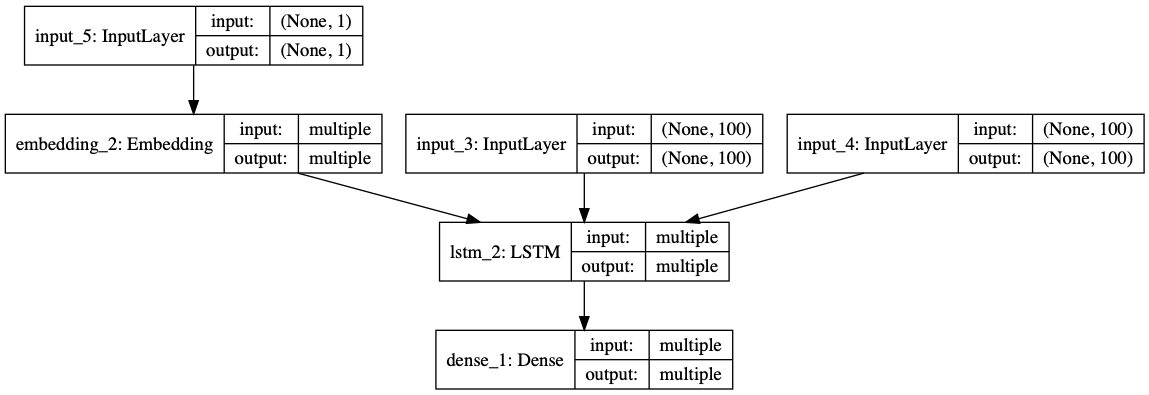

In [34]:
plot_model(decoder_model, to_file='models/model_prd_dec_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
pickle.dump(decoder_model, open('models/model_prd_dec.sav', 'wb'))

## Make predictions
* Create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words
* Pass the padded input sequence to the encoder model and predict the hidden and cell states
* Define the `<sos>` and `<eos>` tokens
* Define the output which contains single words that are predicted.
* The `<sos>` tag is used as the first word to the decoder model.
* Define the output sentence list that will contain the predicted translation
* Execute a loop that runs for the length of the longest sentence in the output
* Predict the output and the hidden and cell states using the previous ones, and store the index of the predicted word
* If the value of the predicted index is equal to the `<eos>` token, the loop terminates
* If the value of the predicted index is greater than 0, the predicted word is retrieved using the index from the output index-to-word dictionary and appended to the output sentence list
* For the next loop cycle, update the hidden and cell states, along with the index of the predicted word to make new predictions.
* After the loop terminates, the words in the output sentence list are concatenated and the resulting string is returned as the translation.

In [44]:
from numpy import argmax

index_to_word_input = {v:k for k,v in inputs_word2index.items()}
index_to_word_output = {v:k for k,v in outputs_word2index.items()}

def translate(input_seq):
    states = encoder_model.predict(input_seq)
    
    sos = outputs_word2index['<sos>']
    eos = outputs_word2index['<eos>']
    
    output_seq = zeros((1, 1))
    output_seq[0, 0] = sos
    
    output_sentence = []
    
    for _ in range(outputs_maxlen):
        output_tokens, h, c = decoder_model.predict([output_seq]+states)
        idx = argmax(output_tokens[0, 0, :])
        
        if idx == eos:
            break     
        word = ''
        if idx > 0:
            word = index_to_word_output[idx]
            output_sentence.append(word)
        
        states = [h, c]
        output_seq[0, 0] = idx
    
    return ' '.join(output_sentence)

## Test
* Randomly choose a sentence from the inputs list
* Retrieve the corresponding padded integer sequence for the sentence
* Find the translation for the same

In [57]:
from numpy import random

i = random.choice(len(inputs))
input_seq = encoder_input_sequences[i:i+1]
translation = translate(input_seq)

print('Input:', inputs[i])
print('Response:', translation)

Input: We're both idiots.
Response: estamos están aquí.
